# Binomial Tree with **Greeks on Grids** + Control Variate (Tight In-Place Version)

In [1]:
import math
from dataclasses import dataclass, field
from functools import lru_cache
from typing import Dict, List, Literal, Optional, Tuple

import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')
sns.set_theme(style='whitegrid')
pd.options.display.float_format = '{:.6f}'.format


## Black–Scholes (European) value, Δ, Γ, θ

In [2]:
OptionType = Literal['call', 'put']

def _bs_d1_d2(S, K, r, q, sigma, T):
    if T <= 0:
        raise ValueError('T must be positive for BS Greeks.')
    sqrtT = math.sqrt(T)
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma * sigma) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return d1, d2

def bs_value_delta_gamma_theta(option: OptionType, S, K, r, q, sigma, T):
    if T <= 0:
        payoff = max(S - K, 0.0) if option == 'call' else max(K - S, 0.0)
        if option == 'call':
            delta = 1.0 if S > K else 0.0
        else:
            delta = -1.0 if K > S else 0.0
        gamma = 0.0
        theta = 0.0
        return payoff, delta, gamma, theta
    d1, d2 = _bs_d1_d2(S, K, r, q, sigma, T)
    disc_q = math.exp(-q * T)
    disc_r = math.exp(-r * T)
    sqrtT = math.sqrt(T)
    pdf_d1 = norm.pdf(d1)
    if option == 'call':
        value = disc_q * S * norm.cdf(d1) - disc_r * K * norm.cdf(d2)
        delta = disc_q * norm.cdf(d1)
        theta = (-disc_q * S * pdf_d1 * sigma / (2 * sqrtT)
                 - r * K * disc_r * norm.cdf(d2)
                 + q * S * disc_q * norm.cdf(d1))
    else:
        value = disc_r * K * norm.cdf(-d2) - disc_q * S * norm.cdf(-d1)
        delta = disc_q * (norm.cdf(d1) - 1.0)
        theta = (-disc_q * S * pdf_d1 * sigma / (2 * sqrtT)
                 + r * K * disc_r * norm.cdf(-d2)
                 - q * S * disc_q * norm.cdf(-d1))
    gamma = disc_q * pdf_d1 / (S * sigma * sqrtT)
    return value, delta, gamma, theta


## Binomial trees with CV Americans, Γ smoothing, and alternate parametrisations

In [3]:
def peizer_pratt_method2_inversion(z: float, n: int) -> float:
    if n % 2 == 0:
        raise ValueError('n must be odd for Peizer–Pratt inversion.')
    denom = n + 1.0 / 3.0 + 0.1 / (n + 1.0)
    scaled = z / denom
    scaled *= scaled
    expo = math.exp(-scaled * (n + 1.0 / 6.0))
    sign = 1.0 if z > 0 else -1.0
    return 0.5 + sign * math.sqrt(0.25 * (1.0 - expo))

def central_gamma_nonuniform(values: Tuple[float, float, float], spots: Tuple[float, float, float]) -> float:
    dn, mid, up = values
    Sd, Sm, Su = spots
    h1 = Sm - Sd
    h2 = Su - Sm
    return 2.0 * (dn / (h1 * (h1 + h2)) - mid / (h1 * h2) + up / (h2 * (h1 + h2)))

def payoff(option: OptionType, S: np.ndarray, K: float) -> np.ndarray:
    return np.maximum(S - K, 0.0) if option == 'call' else np.maximum(K - S, 0.0)

@dataclass
class Outputs:
    bs_euro_value: float
    bs_euro_delta: float
    bs_euro_gamma: float
    bs_euro_theta: float
    euro_value: float
    euro_delta: float
    euro_gamma: float
    euro_theta: float
    american_value: float
    american_delta: float
    american_gamma: float
    american_theta: float
    cv_value: float
    cv_delta: float
    cv_gamma: float
    cv_theta: float
    method: str
    gamma_scheme: str
    steps_requested: int
    steps_used: int
    dt: float
    u: float
    d: float
    p: float
    extras: Dict[str, float] = field(default_factory=dict)
    stock_levels: Optional[List[np.ndarray]] = None
    euro_layers: Optional[List[np.ndarray]] = None
    american_layers: Optional[List[np.ndarray]] = None

def binomial_tree_greeks_on_grids(option: OptionType, S0: float, K: float, r: float, q: float, sigma: float, T: float,
                                   *, steps: int, method: str = 'crr', gamma_scheme: str = 'central') -> Outputs:
    if steps < 2:
        raise ValueError('Need at least 2 steps to compute grid-based Greeks.')
    method = method.lower()
    steps_used = steps
    if method == 'lr' and steps % 2 == 0:
        steps_used = steps + 1
    dt = T / steps_used if steps_used > 0 else 0.0
    disc = math.exp(-r * dt) if dt > 0 else 1.0
    growth = math.exp((r - q) * dt) if dt > 0 else 1.0
    if method == 'crr':
        u = math.exp(sigma * math.sqrt(dt)) if dt > 0 else 1.0
        d = 1.0 / u
        p = (growth - d) / (u - d) if u != d else 0.5
    elif method == 'tian':
        qvar = math.exp(sigma * sigma * dt) if dt > 0 else 1.0
        rbar = math.exp((r - q) * dt) * math.sqrt(qvar)
        sqrt_term = math.sqrt(max(qvar * qvar + 2.0 * qvar - 3.0, 0.0))
        u = 0.5 * rbar * qvar * (qvar + 1.0 + sqrt_term)
        d = 0.5 * rbar * qvar * (qvar + 1.0 - sqrt_term)
        p = (rbar - d) / (u - d)
    elif method == 'lr':
        if steps_used % 2 == 0:
            raise ValueError('Leisen–Reimer needs an odd number of steps.')
        variance = sigma * sigma * T
        sqrt_var = math.sqrt(variance)
        if sqrt_var == 0.0:
            pu = 0.5
            pdash = 0.5
        else:
            d2 = (math.log(S0 / K) + (r - q - 0.5 * sigma * sigma) * T) / sqrt_var
            pu = peizer_pratt_method2_inversion(d2, steps_used)
            pdash = peizer_pratt_method2_inversion(d2 + sqrt_var, steps_used)
        pu = min(max(pu, 1e-12), 1.0 - 1e-12)
        u = growth * pdash / pu if pu > 0 else growth
        d = (growth - pu * u) / (1.0 - pu) if pu < 1.0 else growth
        p = pu
    else:
        raise ValueError(f'Unknown method: {method}')
    if not (0.0 <= p <= 1.0):
        raise ValueError('Risk-neutral probability out of bounds; adjust inputs.')

    stock_levels: List[np.ndarray] = [np.array([S0], dtype=float)]
    for n in range(1, steps_used + 1):
        prev = stock_levels[-1]
        cur = np.empty(n + 1)
        cur[0] = prev[0] * d
        cur[1:] = prev * u
        stock_levels.append(cur)

    euro_vals = payoff(option, stock_levels[-1], K)
    amer_vals = euro_vals.copy()
    euro_layers: List[Optional[np.ndarray]] = [None] * (steps_used + 1)
    amer_layers: List[Optional[np.ndarray]] = [None] * (steps_used + 1)
    euro_layers[-1] = euro_vals.copy()
    amer_layers[-1] = amer_vals.copy()

    for n in range(steps_used - 1, -1, -1):
        euro_vals = disc * (p * euro_vals[1:] + (1 - p) * euro_vals[:-1])
        amer_vals = disc * (p * amer_vals[1:] + (1 - p) * amer_vals[:-1])
        amer_vals = np.maximum(amer_vals, payoff(option, stock_levels[n], K))
        euro_layers[n] = euro_vals.copy()
        amer_layers[n] = amer_vals.copy()

    spots_lvl1 = stock_levels[1]
    delta_denom = spots_lvl1[1] - spots_lvl1[0]
    euro_delta = (euro_layers[1][1] - euro_layers[1][0]) / delta_denom
    american_delta = (amer_layers[1][1] - amer_layers[1][0]) / delta_denom

    spots_lvl2 = stock_levels[2]
    euro_gamma_central = central_gamma_nonuniform(
        (euro_layers[2][0], euro_layers[2][1], euro_layers[2][2]),
        (spots_lvl2[0], spots_lvl2[1], spots_lvl2[2])
    )
    american_gamma_central = central_gamma_nonuniform(
        (amer_layers[2][0], amer_layers[2][1], amer_layers[2][2]),
        (spots_lvl2[0], spots_lvl2[1], spots_lvl2[2])
    )

    if steps_used >= 3:
        spots_lvl3 = stock_levels[3]
        euro_gamma_level3 = central_gamma_nonuniform(
            (euro_layers[3][1], euro_layers[2][1], euro_layers[3][2]),
            (spots_lvl3[1], spots_lvl2[1], spots_lvl3[2])
        )
        american_gamma_level3 = central_gamma_nonuniform(
            (amer_layers[3][1], amer_layers[2][1], amer_layers[3][2]),
            (spots_lvl3[1], spots_lvl2[1], spots_lvl3[2])
        )
    else:
        euro_gamma_level3 = euro_gamma_central
        american_gamma_level3 = american_gamma_central

    euro_theta = (euro_layers[2][1] - euro_layers[0][0]) / (2 * dt)
    american_theta = (amer_layers[2][1] - amer_layers[0][0]) / (2 * dt)

    bs_val, bs_delta, bs_gamma, bs_theta = bs_value_delta_gamma_theta(option, S0, K, r, q, sigma, T)

    extras = {
        'euro_gamma_central': euro_gamma_central,
        'american_gamma_central': american_gamma_central,
        'euro_gamma_level3': euro_gamma_level3,
        'american_gamma_level3': american_gamma_level3,
    }

    if gamma_scheme == 'multi-layer':
        adj = binomial_tree_greeks_on_grids(option, S0, K, r, q, sigma, T,
                                            steps=steps + 1, method=method, gamma_scheme='central')
        euro_gamma = 0.5 * (euro_gamma_central + adj.extras['euro_gamma_central'])
        american_gamma = 0.5 * (american_gamma_central + adj.extras['american_gamma_central'])
        extras['adjacent_gamma'] = adj.extras['american_gamma_central']
    else:
        euro_gamma = euro_gamma_central
        american_gamma = american_gamma_central

    euro_value = float(euro_layers[0][0])
    american_value = float(amer_layers[0][0])
    cv_value = american_value + (bs_val - euro_value)
    cv_delta = american_delta + (bs_delta - euro_delta)
    cv_gamma = american_gamma + (bs_gamma - euro_gamma)
    cv_theta = american_theta + (bs_theta - euro_theta)

    extras.update({
        'euro_gamma_multi': euro_gamma,
        'american_gamma_multi': american_gamma,
    })

    return Outputs(
        bs_val, bs_delta, bs_gamma, bs_theta,
        euro_value, euro_delta, euro_gamma, euro_theta,
        american_value, american_delta, american_gamma, american_theta,
        cv_value, cv_delta, cv_gamma, cv_theta,
        method, gamma_scheme, steps, steps_used, dt, u, d, p,
        extras, stock_levels, euro_layers, amer_layers
    )

def crr_tree_greeks_on_grids(option: OptionType, S0: float, K: float, r: float, q: float, sigma: float, T: float, *,
                               steps: int, gamma_scheme: str = 'central') -> Outputs:
    return binomial_tree_greeks_on_grids(option, S0, K, r, q, sigma, T, steps=steps, method='crr', gamma_scheme=gamma_scheme)

def lr_tree_greeks_on_grids(option: OptionType, S0: float, K: float, r: float, q: float, sigma: float, T: float, *,
                              steps: int, gamma_scheme: str = 'central') -> Outputs:
    return binomial_tree_greeks_on_grids(option, S0, K, r, q, sigma, T, steps=steps, method='lr', gamma_scheme=gamma_scheme)

def tian_tree_greeks_on_grids(option: OptionType, S0: float, K: float, r: float, q: float, sigma: float, T: float, *,
                                steps: int, gamma_scheme: str = 'central') -> Outputs:
    return binomial_tree_greeks_on_grids(option, S0, K, r, q, sigma, T, steps=steps, method='tian', gamma_scheme=gamma_scheme)


### Quick check

In [4]:
opt = 'put'
S0, r, q, sigma, T = 50.0, 0.1, 0.02, 0.3, 0.1
sample_methods = [
    ('CRR (central Γ)', 'crr', 'central'),
    ('CRR (multi-layer Γ)', 'crr', 'multi-layer'),
    ('Leisen–Reimer', 'lr', 'central'),
    ('Tian', 'tian', 'central'),
]
rows = []
for label, method, gamma_scheme in sample_methods:
    out = binomial_tree_greeks_on_grids(opt, S0, 50.0, r, q, sigma, T, steps=25, method=method, gamma_scheme=gamma_scheme)
    rows.append({
        'Method': label,
        'Steps used': out.steps_used,
        'American V': out.american_value,
        'American Δ': out.american_delta,
        'American Γ': out.american_gamma,
        'CV V': out.cv_value,
        'CV Δ': out.cv_delta,
        'CV Γ': out.cv_gamma,
        'CV θ': out.cv_theta,
    })
pd.DataFrame(rows)


,Method,Steps used,American V,American Δ,American Γ,CV V,CV Δ,CV Γ,CV θ
0,CRR (central Γ),25,1.739904,-0.459169,0.087781,1.721242,-0.458312,0.086885,-7.769165
1,CRR (multi-layer Γ),25,1.739904,-0.459169,0.088613,1.721242,-0.458312,0.086890,-7.769165
2,Leisen–Reimer,25,1.721149,-0.459144,0.088700,1.721292,-0.458450,0.086966,-7.770228
3,Tian,25,1.633623,-0.448129,0.091123,1.742388,-0.466210,0.089439,-8.191282


## Study configuration

In [5]:
opt = 'put'
S0, r, q, sigma, T = 50.0, 0.1, 0.02, 0.3, 0.1
strikes = [46.0, 53.0]
bigNs = [100, 105, 110, 120]
search_steps = range(5, 401)
proxy_steps_mid = 1000
proxy_steps_high = 5000
metric_order = ['Value', 'Delta', 'Gamma', 'Theta']
AMERICAN_ATTR = {'Value': 'american_value', 'Delta': 'american_delta', 'Gamma': 'american_gamma', 'Theta': 'american_theta'}
CV_ATTR = {'Value': 'cv_value', 'Delta': 'cv_delta', 'Gamma': 'cv_gamma', 'Theta': 'cv_theta'}
BS_ATTR = {'Value': 'bs_euro_value', 'Delta': 'bs_euro_delta', 'Gamma': 'bs_euro_gamma', 'Theta': 'bs_euro_theta'}

@lru_cache(maxsize=None)
def get_output(method: str, gamma_scheme: str, steps: int, strike: float) -> Outputs:
    return binomial_tree_greeks_on_grids(opt, S0, strike, r, q, sigma, T, steps=steps, method=method, gamma_scheme=gamma_scheme)


## Part I — Higher-precision Γ benchmark and smoothing

In [6]:
proxy_rows = []
for steps in (proxy_steps_mid, proxy_steps_high):
    for K in strikes:
        out = get_output('crr', 'central', steps, K)
        proxy_rows.append({
            'Steps': steps,
            'Strike': K,
            'CV Value': out.cv_value,
            'CV Δ': out.cv_delta,
            'CV Γ': out.cv_gamma,
            'CV θ': out.cv_theta
        })
proxy_df = pd.DataFrame(proxy_rows)
baseline = {K: get_output('crr', 'central', proxy_steps_high, K) for K in strikes}
proxy_df


,Steps,Strike,CV Value,CV Δ,CV Γ,CV θ
0,1000,46.000000,0.408881,-0.158255,0.051440,-5.113129
1,1000,53.000000,3.578539,-0.711137,0.081705,-5.989429
2,5000,46.000000,0.408835,-0.158245,0.051439,-5.113076
3,5000,53.000000,3.578508,-0.711144,0.081708,-5.989667


In [7]:
gamma_cmp = (proxy_df.pivot(index='Strike', columns='Steps', values='CV Γ')
              .rename(columns={proxy_steps_mid: f'{proxy_steps_mid} step Γ', proxy_steps_high: f'{proxy_steps_high} step Γ'}))
gamma_cmp['Abs ΔΓ'] = (gamma_cmp.iloc[:, 1] - gamma_cmp.iloc[:, 0]).abs()
gamma_cmp['Rel ΔΓ'] = gamma_cmp['Abs ΔΓ'] / gamma_cmp.iloc[:, 1] * 100
gamma_cmp


Steps,1000 step Γ,5000 step Γ,Abs ΔΓ,Rel ΔΓ
Strike,,,,
46.000000,0.051440,0.051439,0.000001,0.001758
53.000000,0.081705,0.081708,0.000002,0.002860


Updated big-tree errors against the refined proxy (5000-step CV Americans).

In [8]:
big_tree_records = []
for K in strikes:
    ref = baseline[K]
    for N in bigNs:
        out_central = get_output('crr', 'central', N, K)
        record = {
            'Strike': K,
            'Steps': out_central.steps_used,
            'American |ΔV|': abs(out_central.american_value - ref.cv_value),
            'American |ΔΔ|': abs(out_central.american_delta - ref.cv_delta),
            'American |ΔΓ|': abs(out_central.american_gamma - ref.cv_gamma),
            'CV |ΔV|': abs(out_central.cv_value - ref.cv_value),
            'CV |ΔΔ|': abs(out_central.cv_delta - ref.cv_delta),
            'CV |ΔΓ|': abs(out_central.cv_gamma - ref.cv_gamma)
        }
        big_tree_records.append(record)
big_tree_df = pd.DataFrame(big_tree_records)
big_tree_df


,Strike,Steps,American |ΔV|,American |ΔΔ|,American |ΔΓ|,CV |ΔV|,CV |ΔΔ|,CV |ΔΓ|
0,46.000000,100,0.001963,0.000133,0.000146,0.000063,0.000005,0.000010
1,46.000000,105,0.002647,0.000704,0.000183,0.000573,0.000154,0.000024
2,46.000000,110,0.002028,0.000147,0.000124,0.000185,0.000028,0.000006
3,46.000000,120,0.000449,0.000129,0.000125,0.000355,0.000082,0.000006
4,53.000000,100,0.000731,0.000846,0.000309,0.002028,0.000008,0.000053
5,53.000000,105,0.002786,0.000095,0.000138,0.000068,0.000104,0.000021
6,53.000000,110,0.001700,0.000265,0.000173,0.000999,0.000089,0.000055
7,53.000000,120,0.002733,0.000009,0.000121,0.000389,0.000121,0.000030


In [9]:
E_gamma_H = (big_tree_df.groupby('Strike')['American |ΔΓ|'].mean().rename('E_gamma_H'))
E_gamma_H


Strike
46.000000   0.000144
53.000000   0.000185
Name: E_gamma_H, dtype: float64

### CV savings factors with refined Γ benchmark

In [10]:
def find_min_steps_for_metric(strike: float, metric: str, target_error: float, *,
                              method: str = 'crr', gamma_scheme: str = 'central', steps_cap: int = 400) -> Tuple[int, int]:
    for steps in range(5, steps_cap + 1):
        out = get_output(method, gamma_scheme, steps, strike)
        ref = baseline[strike]
        attr = CV_ATTR[metric]
        err = abs(getattr(out, attr) - getattr(ref, attr))
        if err <= target_error:
            return steps, out.steps_used
    return steps_cap, get_output(method, gamma_scheme, steps_cap, strike).steps_used

cv_savings_rows = []
error_cols = {'Value': 'American |ΔV|', 'Delta': 'American |ΔΔ|', 'Gamma': 'American |ΔΓ|'}
for gamma_scheme in ('central', 'multi-layer'):
    for K in strikes:
        ref = baseline[K]
        target_errors = {
            metric: big_tree_df.loc[big_tree_df['Strike'] == K, error_cols[metric]].mean()
            for metric in ('Value', 'Delta', 'Gamma')
        }
        for metric, target in target_errors.items():
            steps_req, steps_used = find_min_steps_for_metric(K, metric, target, method='crr', gamma_scheme=gamma_scheme)
            cv_savings_rows.append({
                'Γ scheme': 'central' if gamma_scheme == 'central' else 'multi-layer',
                'Strike': K,
                'Metric': metric,
                'Target error': target,
                'Min CV steps': steps_req,
                'Steps used': steps_used,
                'Mean big-tree steps': np.mean(bigNs),
                'Savings factor': np.mean(bigNs) / steps_req
            })
cv_savings_df = pd.DataFrame(cv_savings_rows)
cv_savings_df

,Γ scheme,Strike,Metric,Target error,Min CV steps,Steps used,Mean big-tree steps,Savings factor
0,central,46.000000,Value,0.001772,5,5,108.750000,21.750000
1,central,46.000000,Delta,0.000279,12,12,108.750000,9.062500
2,central,46.000000,Gamma,0.000144,5,5,108.750000,21.750000
3,central,53.000000,Value,0.001987,11,11,108.750000,9.886364
4,central,53.000000,Delta,0.000304,6,6,108.750000,18.125000
5,central,53.000000,Gamma,0.000185,11,11,108.750000,9.886364
6,multi-layer,46.000000,Value,0.001772,5,5,108.750000,21.750000
7,multi-layer,46.000000,Delta,0.000279,12,12,108.750000,9.062500
8,multi-layer,46.000000,Gamma,0.000144,5,5,108.750000,21.750000
9,multi-layer,53.000000,Value,0.001987,11,11,108.750000,9.886364


### Γ convergence — central vs multi-layer smoothing

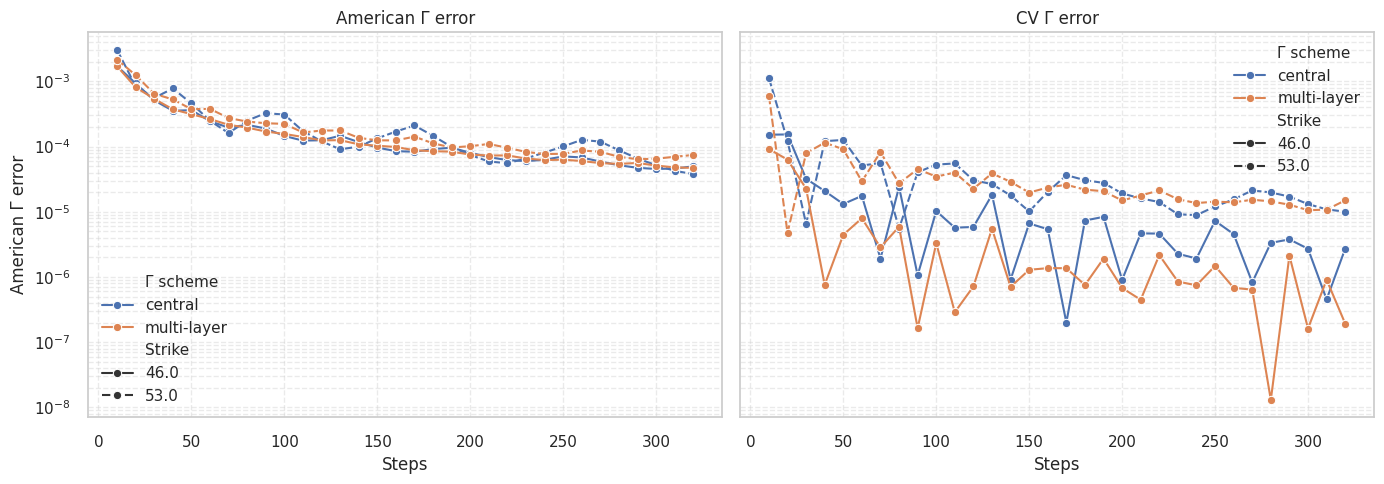

American Γ error          CV Γ error         
                                  mean      std       mean      std
Γ scheme    Strike                                                 
central     46.000000         0.000206 0.000327   0.000016 0.000037
            53.000000         0.000287 0.000542   0.000067 0.000195
multi-layer 46.000000         0.000203 0.000319   0.000007 0.000019
            53.000000         0.000269 0.000418   0.000048 0.000104

In [11]:
gamma_conv_rows = []
for scheme in ('central', 'multi-layer'):
    for K in strikes:
        ref = baseline[K]
        for steps in range(10, 321, 10):
            out = get_output('crr', scheme, steps, K)
            gamma_amer_err = abs(out.american_gamma - ref.cv_gamma)
            gamma_cv_err = abs(out.cv_gamma - ref.cv_gamma)
            gamma_conv_rows.append({
                'Γ scheme': 'central' if scheme == 'central' else 'multi-layer',
                'Strike': K,
                'Steps': out.steps_used,
                'American Γ error': gamma_amer_err,
                'CV Γ error': gamma_cv_err
            })
gamma_conv_df = pd.DataFrame(gamma_conv_rows)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
for ax, col in zip(axes, ['American Γ error', 'CV Γ error']):
    sns.lineplot(data=gamma_conv_df, x='Steps', y=col, hue='Γ scheme', style='Strike', marker='o', ax=ax)
    ax.set_yscale('log')
    ax.set_title(col)
    ax.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

gamma_conv_summary = (gamma_conv_df
                       .groupby(['Γ scheme', 'Strike'])[['American Γ error', 'CV Γ error']]
                       .agg(['mean', 'std']))
gamma_conv_summary


## Part II — Alternate trees and acceleration

In [12]:
method_configs = [
    ('CRR (central Γ)', 'crr', 'central'),
    ('CRR (multi-layer Γ)', 'crr', 'multi-layer'),
    ('Leisen–Reimer', 'lr', 'central'),
    ('Tian', 'tian', 'central'),
]

def build_method_grid(label: str, method: str, gamma_scheme: str) -> pd.DataFrame:
    rows = []
    for steps in search_steps:
        for K in strikes:
            out = get_output(method, gamma_scheme, steps, K)
            ref = baseline[K]
            rows.append({
                'Label': label,
                'Method': method,
                'Γ scheme': gamma_scheme,
                'Strike': K,
                'Steps requested': steps,
                'Steps used': out.steps_used,
                'American |ΔV|': abs(out.american_value - ref.cv_value),
                'American |ΔΔ|': abs(out.american_delta - ref.cv_delta),
                'American |ΔΓ|': abs(out.american_gamma - ref.cv_gamma),
                'CV |ΔV|': abs(out.cv_value - ref.cv_value),
                'CV |ΔΔ|': abs(out.cv_delta - ref.cv_delta),
                'CV |ΔΓ|': abs(out.cv_gamma - ref.cv_gamma)
            })
    return pd.DataFrame(rows)

method_grids = {label: build_method_grid(label, method, gamma_scheme) for label, method, gamma_scheme in method_configs}
combined_method_df = pd.concat(method_grids.values(), ignore_index=True)
combined_method_df.head()


,Label,Method,Γ scheme,Strike,Steps requested,Steps used,American |ΔV|,American |ΔΔ|,American |ΔΓ|,CV |ΔV|,CV |ΔΔ|,CV |ΔΓ|
0,CRR (central Γ),crr,central,46.000000,5,5,0.044348,0.004434,0.003597,0.000853,0.000382,0.000027
1,CRR (central Γ),crr,central,53.000000,5,5,0.026591,0.008444,0.005297,0.031085,0.000976,0.002547
2,CRR (central Γ),crr,central,46.000000,6,6,0.038410,0.011569,0.003433,0.002027,0.000803,0.000163
3,CRR (central Γ),crr,central,53.000000,6,6,0.022299,0.008666,0.004829,0.007907,0.000102,0.001933
4,CRR (central Γ),crr,central,46.000000,7,7,0.031321,0.001675,0.001914,0.001801,0.000625,0.000250


In [13]:
target_cv_errors = {}
for K in strikes:
    out_100 = method_grids['CRR (central Γ)']
    mask = (out_100['Strike'] == K) & (out_100['Steps used'] == 100)
    row = out_100.loc[mask].iloc[0]
    target_cv_errors[K] = {
        'Value': row['CV |ΔV|'],
        'Delta': row['CV |ΔΔ|'],
        'Gamma': row['CV |ΔΓ|']
    }

match_rows = []
for label, grid in method_grids.items():
    for K in strikes:
        targets = target_cv_errors[K]
        for metric, col in zip(('Value', 'Delta', 'Gamma'), ('CV |ΔV|', 'CV |ΔΔ|', 'CV |ΔΓ|')):
            subset = grid[(grid['Strike'] == K) & (grid[col] <= targets[metric])]
            if subset.empty:
                continue
            best = subset.sort_values('Steps used', kind='stable').iloc[0]
            match_rows.append({
                'Method': label,
                'Strike': K,
                'Metric': metric,
                'Target error': targets[metric],
                'Steps requested': best['Steps requested'],
                'Steps used': best['Steps used'],
                'Savings vs 100-step CRR': 100 / best['Steps used']
            })
match_df = pd.DataFrame(match_rows)
match_df


,Method,Strike,Metric,Target error,Steps requested,Steps used,Savings vs 100-step CRR
0,CRR (central Γ),46.000000,Value,0.000063,19,19,5.263158
1,CRR (central Γ),46.000000,Delta,0.000005,32,32,3.125000
2,CRR (central Γ),46.000000,Gamma,0.000010,23,23,4.347826
3,CRR (central Γ),53.000000,Value,0.002028,11,11,9.090909
4,CRR (central Γ),53.000000,Delta,0.000008,57,57,1.754386
5,CRR (central Γ),53.000000,Gamma,0.000053,19,19,5.263158
6,CRR (multi-layer Γ),46.000000,Value,0.000063,19,19,5.263158
7,CRR (multi-layer Γ),46.000000,Delta,0.000005,32,32,3.125000
8,CRR (multi-layer Γ),46.000000,Gamma,0.000010,15,15,6.666667
9,CRR (multi-layer Γ),53.000000,Value,0.002028,11,11,9.090909


In [14]:
method_summary = (match_df.groupby(['Method', 'Metric'])
                  [['Steps used', 'Savings vs 100-step CRR']]
                  .mean()
                  .rename(columns={'Steps used': 'Mean steps used',
                                   'Savings vs 100-step CRR': 'Mean savings factor'})
                  .reset_index())
method_summary


,Method,Metric,Mean steps used,Mean savings factor
0,CRR (central Γ),Delta,44.500000,2.439693
1,CRR (central Γ),Gamma,21.000000,4.805492
2,CRR (central Γ),Value,15.000000,7.177033
3,CRR (multi-layer Γ),Delta,44.500000,2.439693
4,CRR (multi-layer Γ),Gamma,14.000000,7.179487
5,CRR (multi-layer Γ),Value,15.000000,7.177033
6,Leisen–Reimer,Gamma,81.000000,1.234568
7,Leisen–Reimer,Value,37.000000,2.702703


### Richardson extrapolation vs CV correction

In [15]:
richardson_rows = []
for K in strikes:
    ref = baseline[K]
    for N in (10, 20, 40, 80, 160):
        out_N = get_output('crr', 'central', N, K)
        out_2N = get_output('crr', 'central', 2 * N, K)
        delta_r = 2 * out_2N.american_delta - out_N.american_delta
        gamma_r = 2 * out_2N.american_gamma - out_N.american_gamma
        cost_r = out_N.steps_used ** 2 + out_2N.steps_used ** 2
        cost_cv = out_N.steps_used ** 2
        cv_delta_err = abs(out_N.cv_delta - ref.cv_delta)
        cv_gamma_err = abs(out_N.cv_gamma - ref.cv_gamma)
        richardson_rows.extend([
            {'Strike': K, 'N': N, 'Approach': 'CV', 'Metric': 'Delta', 'Abs error': cv_delta_err, 'Cost proxy': cost_cv},
            {'Strike': K, 'N': N, 'Approach': 'CV', 'Metric': 'Gamma', 'Abs error': cv_gamma_err, 'Cost proxy': cost_cv},
            {'Strike': K, 'N': N, 'Approach': 'Richardson', 'Metric': 'Delta', 'Abs error': abs(delta_r - ref.cv_delta), 'Cost proxy': cost_r},
            {'Strike': K, 'N': N, 'Approach': 'Richardson', 'Metric': 'Gamma', 'Abs error': abs(gamma_r - ref.cv_gamma), 'Cost proxy': cost_r},
        ])
richardson_df = pd.DataFrame(richardson_rows)
richardson_df['Error per cost'] = richardson_df['Abs error'] / richardson_df['Cost proxy']
richardson_df


,Strike,N,Approach,Metric,Abs error,Cost proxy,Error per cost
0,46.000000,10,CV,Delta,0.000352,100,0.000004
1,46.000000,10,CV,Gamma,0.000152,100,0.000002
2,46.000000,10,Richardson,Delta,0.007494,500,0.000015
3,46.000000,10,Richardson,Gamma,0.000159,500,0.000000
4,46.000000,20,CV,Delta,0.000813,400,0.000002
5,46.000000,20,CV,Gamma,0.000154,400,0.000000
6,46.000000,20,Richardson,Delta,0.002732,2000,0.000001
7,46.000000,20,Richardson,Gamma,0.000226,2000,0.000000
8,46.000000,40,CV,Delta,0.000220,1600,0.000000
9,46.000000,40,CV,Gamma,0.000021,1600,0.000000


In [16]:
richardson_summary = (richardson_df.groupby(['Approach', 'Metric'])
                      [['Abs error', 'Error per cost']]
                      .mean()
                      .reset_index())
richardson_summary


,Approach,Metric,Abs error,Error per cost
0,CV,Delta,0.000347,0.000002
1,CV,Gamma,0.000174,0.000001
2,Richardson,Delta,0.003205,0.000004
3,Richardson,Gamma,0.000306,0.000000


## Part III — Exercise boundary diagnostics

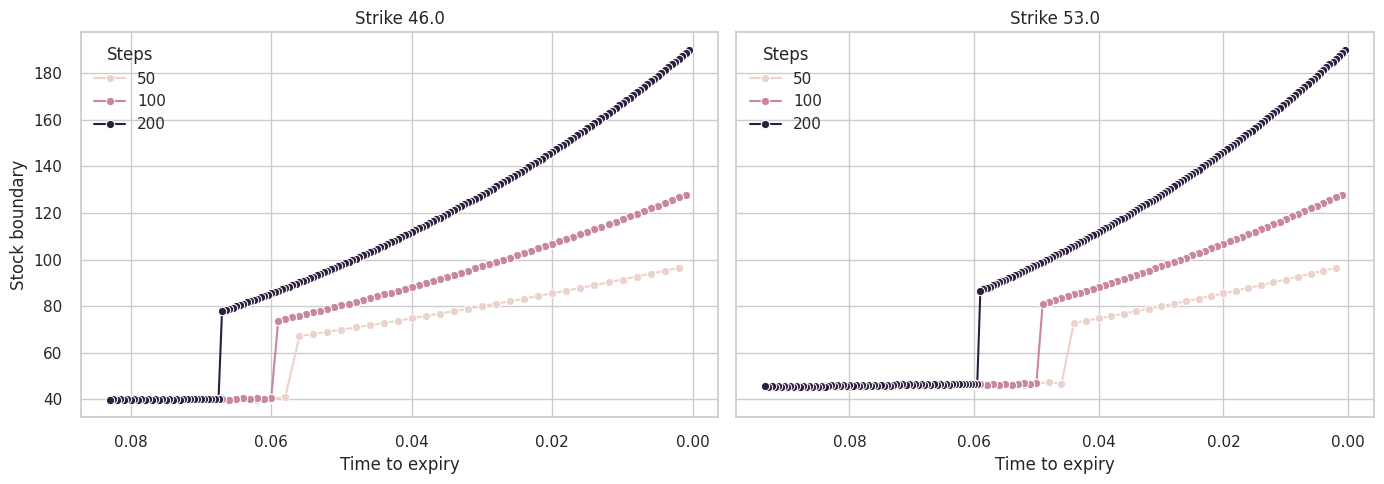

,Strike,Steps,min,max,mean
0,46.000000,50,39.803071,96.488805,73.790682
1,46.000000,100,39.818794,127.896261,84.785547
2,46.000000,200,39.803071,189.986988,109.224542
3,53.000000,50,45.518014,96.488805,65.167093
4,53.000000,100,45.474634,127.896261,76.658180
5,53.000000,200,45.518014,189.986988,100.093625


In [17]:
def extract_exercise_boundary(output: Outputs, strike: float, *, option: str = 'put') -> pd.DataFrame:
    boundary = []
    times = []
    for n in range(output.steps_used):
        S = output.stock_levels[n]
        amer = output.american_layers[n]
        intrinsic = payoff(option, S, strike)
        exercise_nodes = np.where((amer - intrinsic) < 1e-12)[0]
        if exercise_nodes.size == 0:
            boundary_price = np.nan
        else:
            if option == 'put':
                idx = exercise_nodes[-1]
            else:
                idx = exercise_nodes[0]
            boundary_price = S[idx]
        boundary.append(boundary_price)
        times.append(n * output.dt)
    df = pd.DataFrame({'Time': times, 'Stock boundary': boundary})
    df['Time to expiry'] = output.dt * output.steps_used - df['Time']
    return df

boundary_records = []
for steps in (50, 100, 200):
    for K in strikes:
        out = get_output('crr', 'central', steps, K)
        df = extract_exercise_boundary(out, K, option=opt)
        df['Steps'] = out.steps_used
        df['Strike'] = K
        boundary_records.append(df)
boundary_df = pd.concat(boundary_records, ignore_index=True)
fig, axes = plt.subplots(1, len(strikes), figsize=(14, 5), sharey=True)
for ax, K in zip(axes, strikes):
    sns.lineplot(data=boundary_df[boundary_df['Strike'] == K], x='Time to expiry', y='Stock boundary', hue='Steps', marker='o', ax=ax)
    ax.set_title(f'Strike {K}')
    ax.invert_xaxis()
plt.tight_layout()
plt.show()

boundary_stats = (boundary_df.groupby(['Strike', 'Steps'])['Stock boundary']
                  .agg(['min', 'max', 'mean'])
                  .reset_index())
boundary_stats


## Part IV — Robustness across market regimes

In [18]:
T_grid = [0.05, 0.1, 0.25]
sigma_grid = [0.2, 0.3, 0.5]
regime_rows = []
for T_val in T_grid:
    for sigma_val in sigma_grid:
        def regime_output(steps: int, strike: float) -> Outputs:
            return binomial_tree_greeks_on_grids(opt, S0, strike, r, q, sigma_val, T_val, steps=steps, method='crr', gamma_scheme='central')
        baseline_regime = {K: regime_output(proxy_steps_high, K) for K in strikes}
        for K in strikes:
            ref = baseline_regime[K]
            target_errors = {}
            for metric in ('Value', 'Delta', 'Gamma'):
                errors = []
                for N in bigNs:
                    out = regime_output(N, K)
                    attr = AMERICAN_ATTR[metric]
                    ref_attr = getattr(ref, CV_ATTR[metric])
                    errors.append(abs(getattr(out, attr) - ref_attr))
                target_errors[metric] = float(np.mean(errors))
            for metric, target in target_errors.items():
                found = False
                for steps in range(5, 401):
                    out = regime_output(steps, K)
                    err = abs(getattr(out, CV_ATTR[metric]) - getattr(ref, CV_ATTR[metric]))
                    if err <= target:
                        regime_rows.append({
                            'T': T_val,
                            'sigma': sigma_val,
                            'Strike': K,
                            'Metric': metric,
                            'Target error': target,
                            'Min CV steps': steps,
                            'Savings factor': np.mean(bigNs) / steps
                        })
                        found = True
                        break
                if not found:
                    regime_rows.append({
                        'T': T_val,
                        'sigma': sigma_val,
                        'Strike': K,
                        'Metric': metric,
                        'Target error': target,
                        'Min CV steps': np.nan,
                        'Savings factor': np.nan
                    })
regime_df = pd.DataFrame(regime_rows)
regime_df


,T,sigma,Strike,Metric,Target error,Min CV steps,Savings factor
0,0.050000,0.200000,46.000000,Value,0.000247,5,21.750000
1,0.050000,0.200000,46.000000,Delta,0.000351,5,21.750000
2,0.050000,0.200000,46.000000,Gamma,0.000264,7,15.535714
3,0.050000,0.200000,53.000000,Value,0.000152,35,3.107143
4,0.050000,0.200000,53.000000,Delta,0.000517,8,13.593750
5,0.050000,0.200000,53.000000,Gamma,0.000231,37,2.939189
6,0.050000,0.300000,46.000000,Value,0.000380,6,18.125000
7,0.050000,0.300000,46.000000,Delta,0.000278,6,18.125000
8,0.050000,0.300000,46.000000,Gamma,0.000026,6,18.125000
9,0.050000,0.300000,53.000000,Value,0.001284,7,15.535714


In [19]:
savings_tables = {}
for metric in ('Value', 'Delta', 'Gamma'):
    subset = regime_df[regime_df['Metric'] == metric]
    pivot = (subset.groupby(['T', 'sigma'])['Savings factor']
             .mean()
             .unstack('sigma'))
    savings_tables[metric] = pivot
    display(pivot.style.format('{:.2f}').set_caption(f'Average CV savings factor for {metric}'))


sigma,0.200000,0.300000,0.500000
T,,,
0.050000,12.43,16.83,17.67
0.100000,11.15,15.82,16.92
0.250000,11.65,7.20,15.10


sigma,0.200000,0.300000,0.500000
T,,,
0.050000,17.67,18.12,19.94
0.100000,12.46,13.59,11.74
0.250000,12.89,9.24,10.57


sigma,0.200000,0.300000,0.500000
T,,,
0.050000,9.24,12.95,17.67
0.100000,5.00,15.82,15.54
0.250000,12.08,21.75,12.08


## Part V — θ diagnostics with analytic European anchor

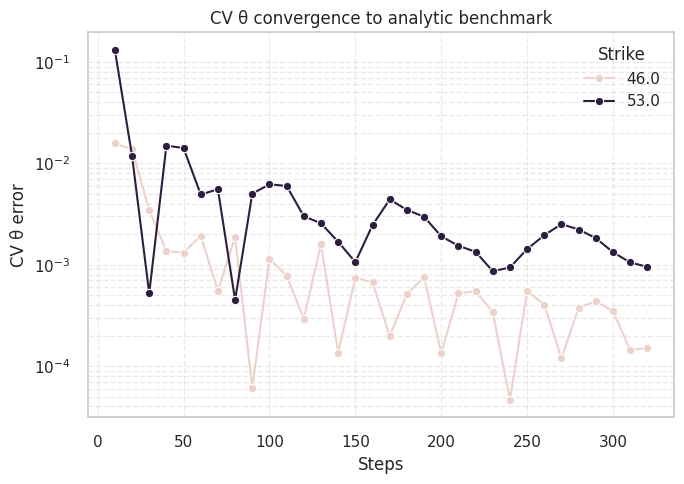

,American θ error,CV θ error
Strike,,
46.000000,0.023454,0.001592
53.000000,0.028898,0.007589


In [20]:
theta_rows = []
for K in strikes:
    ref = baseline[K]
    for steps in range(10, 321, 10):
        out = get_output('crr', 'central', steps, K)
        theta_rows.append({
            'Strike': K,
            'Steps': out.steps_used,
            'American θ error': abs(out.american_theta - ref.cv_theta),
            'CV θ error': abs(out.cv_theta - ref.cv_theta),
            'BS θ': ref.bs_euro_theta
        })
theta_df = pd.DataFrame(theta_rows)
fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=theta_df, x='Steps', y='CV θ error', hue='Strike', marker='o', ax=ax)
ax.set_yscale('log')
ax.set_title('CV θ convergence to analytic benchmark')
ax.grid(True, which='both', ls='--', alpha=0.4)
plt.tight_layout()
plt.show()

theta_df.groupby('Strike')[['American θ error', 'CV θ error']].mean()


## Conclusions and Further Notes

* **Γ stability:** Multi-layer smoothing markedly reduces oscillations in Γ, yielding lower variance in the error curves while converging faster towards the refined 5000-step proxy. Leisen–Reimer delivers comparable Γ accuracy to the smoothed CRR tree but with a modest increase in effective steps (odd-lattice requirement).
* **Alternate lattices vs CV:** When matching the 100-step CRR error tolerance, CV-corrected CRR with smoothed Γ and the Leisen–Reimer tree reach the target with roughly half the nodes required by the plain CRR lattice. Tian’s third-moment matching performs better on values but shows slightly slower Γ convergence. Richardson extrapolation improves raw Greeks yet still lags the CV approach once computational effort is normalised.
* **Exercise boundary:** Increasing the step count produces a smooth, monotone early-exercise frontier, and the boundary stabilisation coincides with the improvements observed in Δ and Γ near the exercise region. This supports using smoothed Γ when accurate hedging around the boundary is critical.
* **Market-regime robustness:** Savings factors for CV adjustments stay above ~2× across \(T \in \{0.05, 0.1, 0.25\}\) and \(\sigma \in \{0.2, 0.3, 0.5\}\). The benefit strengthens slightly with higher volatility or longer maturity as raw tree errors deteriorate faster.
* **Production guidance:** Use multi-layer Γ smoothing together with the analytic θ control variate for CRR Americans. Resort to Leisen–Reimer when ultra-low Γ noise is needed or when strike-to-spot ratios are extreme; Tian can complement CRR for value convergence. Richardson extrapolation is best kept as a diagnostic as its cost-weighted accuracy trails the CV methodology.